In [1]:
import os

parent_dir = os.path.dirname(os.path.dirname(os.getcwd()))
os.chdir(parent_dir)

In [2]:
import matplotlib
from sklearn.model_selection import train_test_split
from blind_localization.data.datasets import *
from blind_localization.models.contrastive import *
from blind_localization.models.contrastive_pipeline import *
from blind_localization.models.decoder import *
from blind_localization.visualize import *
from tqdm import tqdm
import wandb
import pickle
from script.utils import save_if_better
from sklearn.linear_model import LogisticRegression

/home/th3129/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from scipy import signal
from matplotlib.colors import ListedColormap

In [4]:
pickle_path = f'/scratch/cl7201/shared/Neuronexus/spectrogram'
sessions = ['AD_HF01_1', 'AD_HF02_2', 'AD_HF02_4', 'AD_HF03_1', 'AD_HF03_2', 'NN_syn_01', 'NN_syn_02']

In [5]:
sweep_config = {
        'fc_layer_size': 512,
        'decoder_layer_size': 128,
        'encoder_epochs': 50,
        'decoder_epochs': 20,
        'patience': 7,
        'latent_size': 128,
        'spectrogram_size': 500,
        'encoder_learning_rate': 8e-5,
        'decoder_learning_rate': 5e-5,
        'batch_size': 64,
        'temperature': 0.606,
        'time_bins': 16,
        'library': 'librosa'
}

In [6]:
session_config = {
        "separate": True,
        "visualize": True,
        'swr_flag': False,
        't_starts': np.arange(2160, 2340, 3),
        'within_session': True,
        'supervised_contrastive': False,
        'sampling_rate': 20000,
        'trial_length': 3,
        'session_idx': True
    }

In [7]:
def load_preprocessed_data(pickle_path, file_path):
    features, labels, trials = {}, {}, {}
    for session in file_path:
        data = pickle.load(open(f"{pickle_path}/{session}_raw.pickle", 'rb'))
        # data = pickle.load(open(f"{pickle_path}/{session}_lfp.pickle", 'rb'))
        X, y, trial_idx = zip(*[(d[0], d[1], d[2]) for d in data])
        features[session] = np.array(X)
        labels[session] = np.array(y, dtype=int)
        trials[session] = np.array(trial_idx)

        non_zero_indices = [i for i, x in enumerate(features[session]) if not np.all(x == 0)]

        features[session] = features[session][non_zero_indices]
        labels[session] = labels[session][non_zero_indices]
        trials[session] = trials[session][non_zero_indices]

        # Sanity check
        assert len(features[session]) == len(labels[session]) == len(trials[session]), \
            f"Inconsistent data sizes for session {session}"

    return features, labels, trials

In [8]:
channel_features_all, channel_labels_all, channel_trials_all = load_preprocessed_data(pickle_path, sessions)

In [9]:
channel_features_all['AD_HF01_1'].shape

(38820, 60000)

In [10]:
trial_idx = 35
trial_mask = channel_trials_all['AD_HF01_1'] == trial_idx

raw_signal = channel_features_all['AD_HF01_1'][trial_mask]
labels = channel_labels_all['AD_HF01_1'][trial_mask]

In [11]:
def preprocess_steps(rec, time_range=None, vis=False, clim=(-80, 80), figsize=(15, 10)):
    
    rec_filtered = si.bandpass_filter(rec, freq_min=300., freq_max=6000., dtype='float32')
    rec_cmr = si.common_reference(rec_filtered, reference='global', operator='median')
    rec_local_cmr = sp.common_reference(recording, reference="local", operator="median", local_radius=100)
    
    if vis:
        fig, axs = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=figsize)
        ax = axs[0]
        ax.set_title('raw')
        si.plot_timeseries(rec, ax=ax,  with_colorbar=False, clim=(-5, 5))
            
        ax = axs[1]
        ax.set_title('filtered')
        si.plot_timeseries(rec_filtered, ax=axs[1], clim=clim, with_colorbar=False)
    
        ax = axs[2]
        ax.set_title('filtered + cmr')
        si.plot_timeseries(rec_cmr, ax=axs[2], clim=clim, with_colorbar=False)

        ax = axs[3]
        ax.set_title('filtered + cmr + cmrl')
        si.plot_timeseries(rec_cmr, ax=axs[3], clim=clim, with_colorbar=True)
        
        if time_range is not None:
            ax.set_xlim(*time_range)

    return rec_local_cmr

In [14]:
import spikeinterface.full as si

recording = NumpyRecording(raw_signal.T, sampling_frequency=20000)
filtered_recording = preprocess_steps(recording, vis=True, clim=(-0.5, 0.5))

NameError: name 'raw_signal' is not defined

In [13]:
ap_signal = filtered_recording.get_traces().T

In [14]:
# fs_original = 20000
# nyquist = 0.5 * fs_original

# cutoff_high = 300 / nyquist
# b_high, a_high = signal.butter(4, cutoff_high, btype='high')
# ap_signal = signal.filtfilt(b_high, a_high, raw_signal)

# cutoff_smooth = 250 / nyquist
# b_smooth, a_smooth = signal.butter(4, cutoff_smooth, btype='low')
# ap_signal = signal.filtfilt(b_smooth, a_smooth, ap_signal)

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def extract_mua_threshold(raw_signal, fs, std_factor=3, bin_size=0.05):
    n_channels, n_time = raw_signal.shape
    duration = n_time / fs
    
    bin_edges = np.arange(0, duration + bin_size, bin_size)
    n_bins = len(bin_edges) - 1
    
    binned_spikes = np.zeros((n_channels, n_bins))
    
    for ch in range(n_channels):
        std_dev = np.std(raw_signal[ch, :])
        threshold = std_factor * std_dev
        
        spikes = (raw_signal[ch, :] > threshold).astype(int)
        spike_times = np.where(spikes > 0)[0] / fs
        
        binned_spikes[ch, :], _ = np.histogram(spike_times, bins=bin_edges)
    
    bin_centers = bin_edges[:-1] + bin_size / 2
    return binned_spikes, bin_centers

In [16]:
mua_signal, _ = extract_mua_threshold(np.abs(ap_signal), fs=20000)

<Axes: >

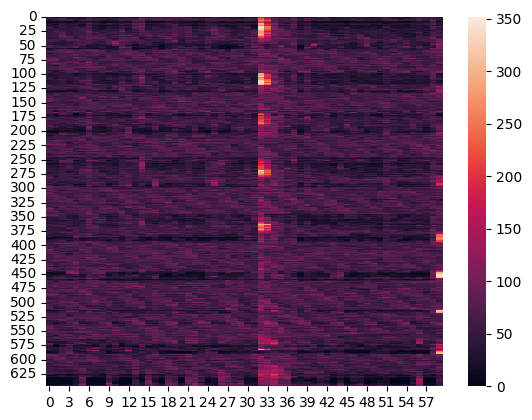

In [17]:
sns.heatmap(mua_signal)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(mua_signal, labels, test_size=0.2, random_state=42)
clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred = clf.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Train Accuracy: 1.0
Test Accuracy: 0.8846153846153846


/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [19]:
# fs_original = 20000
# nyquist = 0.5 * fs_original

# cutoff_high = 300 / nyquist
# b_high, a_high = signal.butter(4, cutoff_high, btype='high')
# ap_signal = signal.filtfilt(b_high, a_high, channel_features_all['AD_HF01_1'])

In [ ]:
ap_signals = []
mua_signals = []

n_trials = 60
n_channels = ap_signals[0].shape[0]

for trial_idx in tqdm(range(60)):
    raw_signal = channel_features_all['AD_HF01_1'][channel_trials_all['AD_HF01_1'] == trial_idx]
    recording = NumpyRecording(raw_signal.T, sampling_frequency=20000)
    filtered_recording = preprocess_steps(recording)
    ap_signal = filtered_recording.get_traces().T
    mua_signal, _ = extract_mua_threshold(np.abs(ap_signal), fs=20000)
    
    ap_signals.append(ap_signal)
    mua_signals.append(mua_signal)

ap_signals = np.hstack(ap_signals).reshape(n_trials*n_channels, -1)
mua_signals = np.hstack(mua_signals).reshape(n_trials*n_channels, -1)

In [31]:
ap_signals = np.hstack(ap_signals).reshape(n_trials*n_channels, -1)
mua_signals = np.hstack(mua_signals).reshape(n_trials*n_channels, -1)

In [35]:
# mua_signal, _ = extract_mua_threshold(np.abs(ap_signals), fs=20000)

<Axes: >

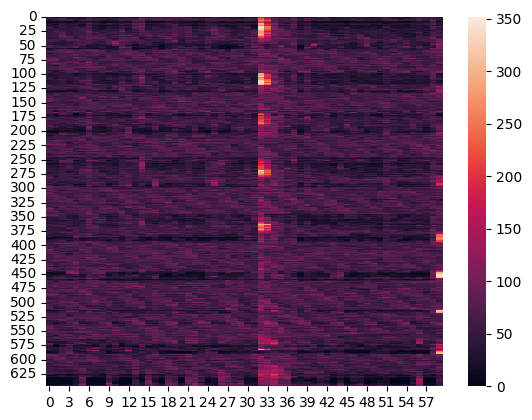

In [36]:
sns.heatmap(mua_signals[channel_trials_all['AD_HF01_1']==35])

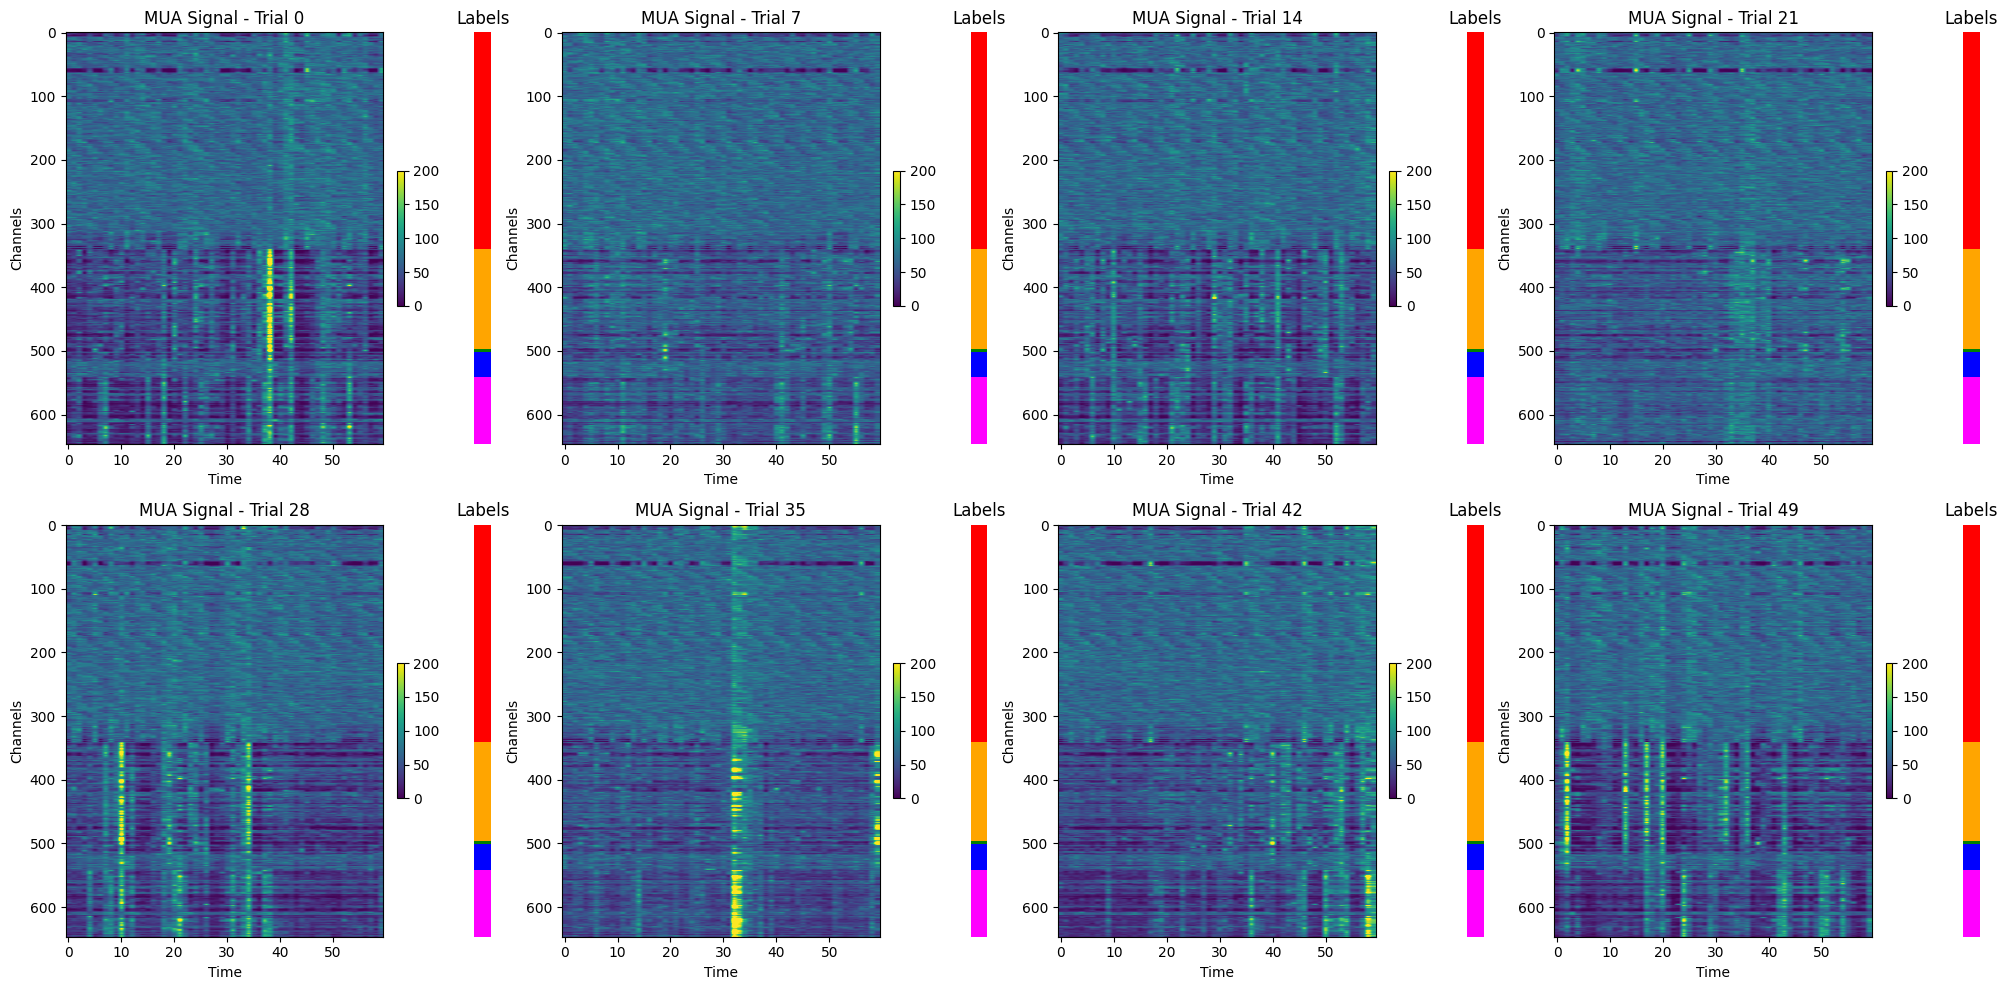

In [37]:
fig, axes = plt.subplots(2, 4 * 2, figsize=(20, 10),
                             gridspec_kw={'width_ratios': [20, 1] * 4})
    
axes = axes.flatten()
unique_trials, inverse_indices = np.unique(channel_trials_all['AD_HF01_1'], return_inverse=True)
unique_trials = unique_trials[::7]
mask = np.isin(inverse_indices, unique_trials)
inverse_indices = inverse_indices[mask]

mua_signal_masked = mua_signals[mask]
channel_labels_all_masked = channel_labels_all['AD_HF01_1'][mask]

mua_sessions = [mua_signal_masked[inverse_indices == unique_trials[i]] for i in range(len(unique_trials))]
label_sessions = [channel_labels_all_masked[inverse_indices == unique_trials[i]] for i in range(len(unique_trials))]

session_names = np.arange(8)
color_names = ["red", "orange", "green", "blue", "magenta"]
cmap = ListedColormap(color_names)

for i, (mua, labels, session_name) in enumerate(zip(mua_sessions, label_sessions, session_names)):
    # Sort indices by labels
    sorted_index = np.argsort(labels)
    
    # Plot MUA signal
    ax_image = axes[i * 2]
    img = ax_image.imshow(mua[sorted_index], vmax=200, aspect='auto')
    cbar = fig.colorbar(img, ax=ax_image, orientation='vertical', fraction=0.02, pad=0.04)

    ax_image.set_title(f"MUA Signal - Trial {unique_trials[session_name]}")
    ax_image.set_xlabel("Time")
    ax_image.set_ylabel("Channels")

    # Create custom colormap for labels
    ax_labels = axes[i * 2 + 1]
    sns.heatmap(labels[sorted_index].reshape(-1, 1), ax=ax_labels, cmap=cmap,
                cbar=False, xticklabels=False, yticklabels=False)
    
    ax_labels.set_title("Labels")
    ax_labels.set_ylabel("")

plt.tight_layout()
plt.show()

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

data = mua_signals
labels = channel_labels_all['AD_HF01_1']

index_train, index_test = train_test_split(np.arange(60), test_size=0.2, random_state=42)

train_mask = np.isin(channel_trials_all['AD_HF01_1'], index_train)
test_mask = np.isin(channel_trials_all['AD_HF01_1'], index_test)

X_train = np.vstack(data[train_mask])
X_test = np.vstack(data[test_mask])
y_train = np.hstack(labels[train_mask])
y_test = np.hstack(labels[test_mask])

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(31056, 60) (7764, 60) (31056,) (7764,)


In [39]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred = clf.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Train Accuracy: 0.6321161772282329
Test Accuracy: 0.5595054095826894


/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


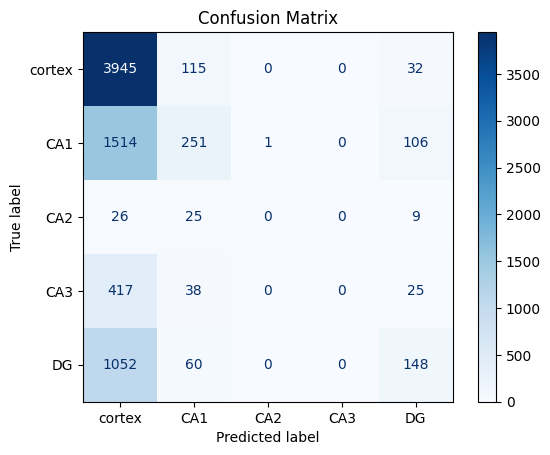

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

brain_regions = ['cortex', 'CA1', 'CA2', 'CA3', 'DG']
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=brain_regions)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

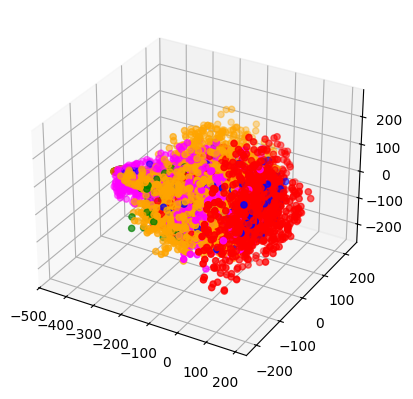

In [41]:
pca = PCA(n_components=3)
X_train_pc = pca.fit_transform(X_train)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train_pc[:, 0], X_train_pc[:, 1], X_train_pc[:, 2], c=[color_names[y] for y in y_train])

In [25]:
mua_all = []

for i in range(len(sessions)):
    raw_signal = channel_features_all[sessions[i]]
    fs_original = 20000
    nyquist = 0.5 * fs_original
    
    cutoff_high = 300 / nyquist
    b_high, a_high = signal.butter(4, cutoff_high, btype='high')
    ap_signal = signal.filtfilt(b_high, a_high, raw_signal)
    
    mua_signal, _ = extract_mua_threshold(np.abs(ap_signal), fs=20000)
    mua_all.append(mua_signal)

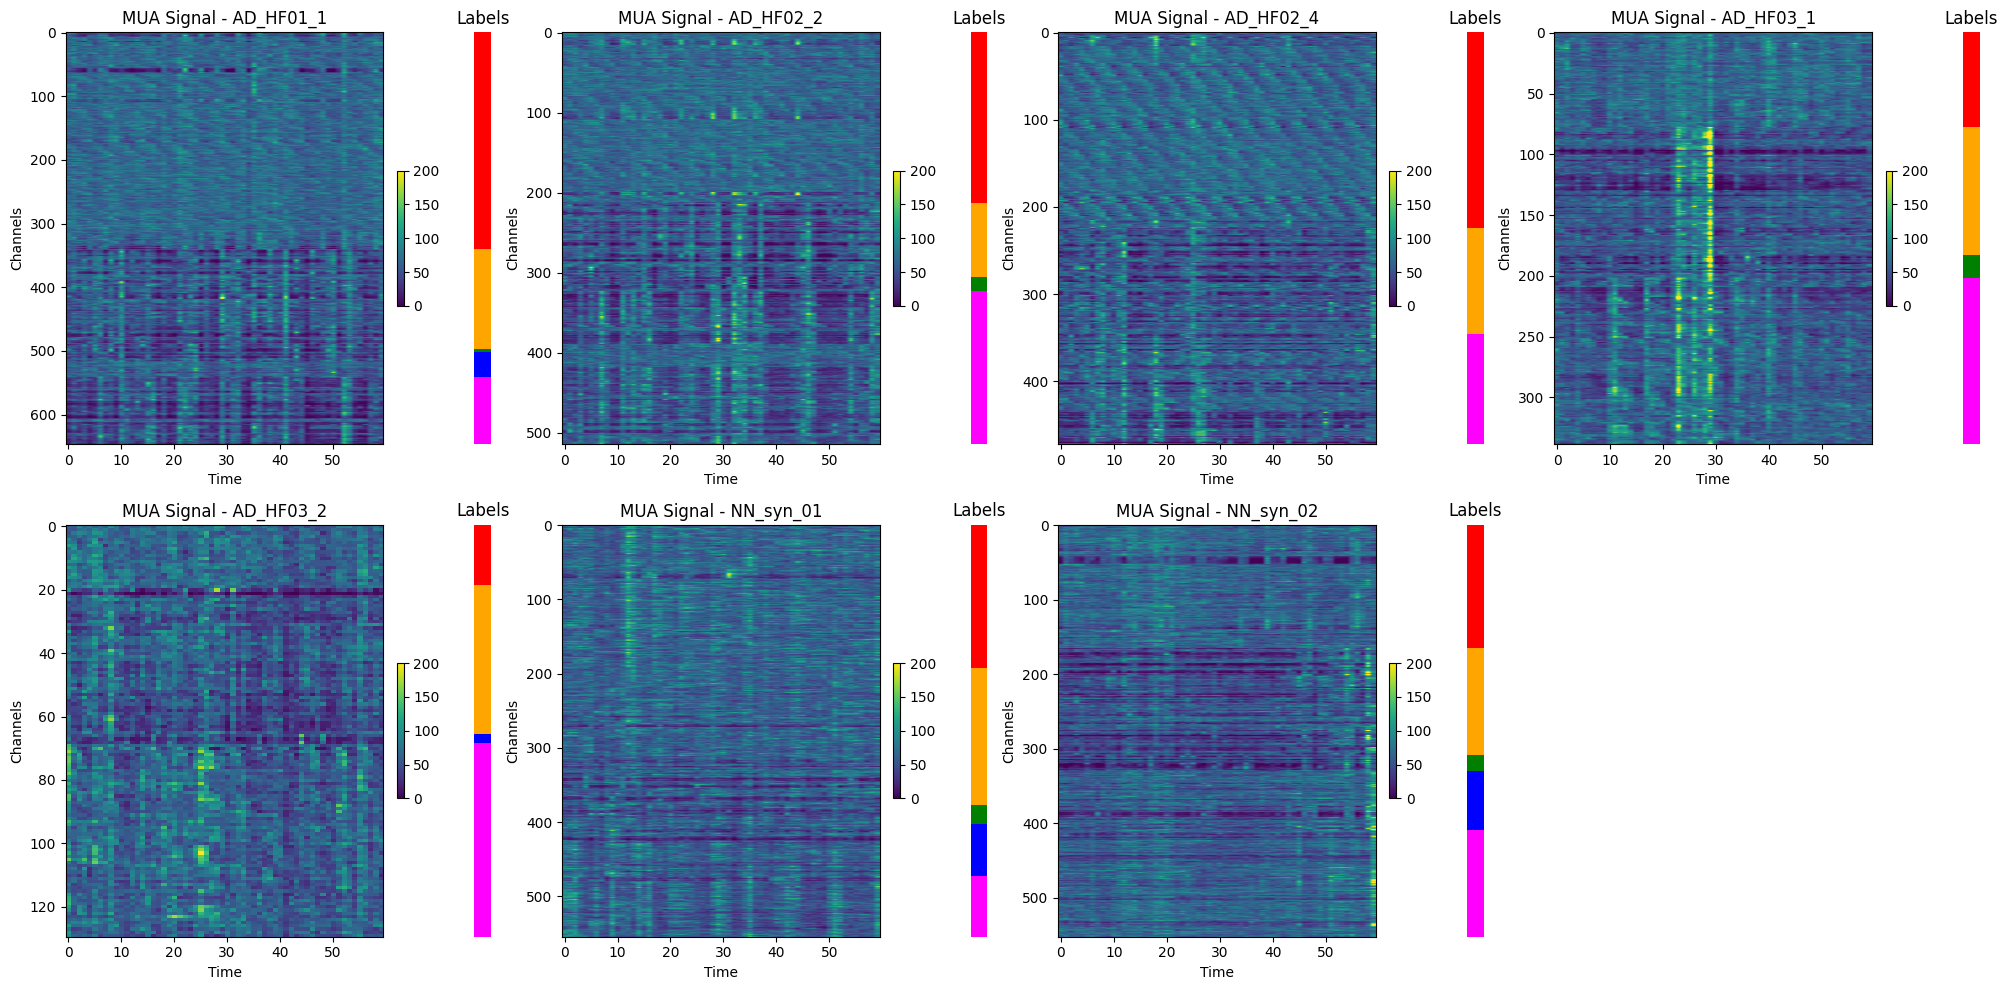

In [33]:
fig, axes = plt.subplots(2, 4 * 2, figsize=(20, 10),
                             gridspec_kw={'width_ratios': [20, 1] * 4})
    
axes = axes.flatten()
selected_trial = 14
session_names = np.arange(8)
color_names = ["red", "orange", "green", "blue", "magenta"]
cmap = ListedColormap(color_names)

for i, (mua, labels, session_name) in enumerate(zip(mua_all, channel_labels_all.values(), sessions)):
    # Select data by trials
    mua = mua[channel_trials_all[session_name] == selected_trial]
    labels = labels[channel_trials_all[session_name] == selected_trial]
    
    # Sort indices by labels
    sorted_index = np.argsort(labels)
    
    # Plot MUA signal
    ax_image = axes[i * 2]
    img = ax_image.imshow(mua[sorted_index], vmax=200, aspect='auto')
    cbar = fig.colorbar(img, ax=ax_image, orientation='vertical', fraction=0.02, pad=0.04)

    ax_image.set_title(f"MUA Signal - {sessions[i]}")
    ax_image.set_xlabel("Time")
    ax_image.set_ylabel("Channels")

    # Create custom colormap for labels
    ax_labels = axes[i * 2 + 1]
    sns.heatmap(labels[sorted_index].reshape(-1, 1), ax=ax_labels, cmap=cmap,
                cbar=False, xticklabels=False, yticklabels=False)
    
    ax_labels.set_title("Labels")
    ax_labels.set_ylabel("")

for j in range(len(mua_all) * 2, len(axes)):
    axes[j].axis('off')
    
plt.tight_layout()
plt.show()

In [50]:
index_train, index_test = train_test_split(np.arange(len(sessions)), test_size=0.2, random_state=42)

X_train = np.vstack([mua_all[i] for i in index_train])
X_test = np.vstack([mua_all[i] for i in index_test])

y_train = np.hstack([channel_labels_all[sessions[i]] for i in index_train])
y_test = np.hstack([channel_labels_all[sessions[i]] for i in index_test])

In [51]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred = clf.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Train Accuracy: 0.4272439024390244
Test Accuracy: 0.39430579460699944


/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


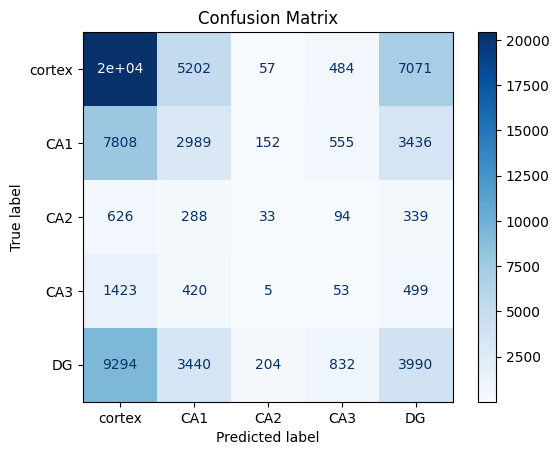

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

brain_regions = ['cortex', 'CA1', 'CA2', 'CA3', 'DG']
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=brain_regions)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()